# HW 10 CLUSTERING BUSINESS

# cluster time trends in NYC businesses: 
# DATA
# Census Business data:
## download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
## and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



In [2]:
'''
$ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

$ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

$ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

'''

'\n$ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done\n\n$ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\\/CBP_CSV/zbp0$y\totals.zip; done\n\n$ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\\/CBP_CSV/zbp$y\totals.zip; done\n\n'

# NYC zip codes shape file is here
## http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (Ntimestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

In [1]:
# import some packages
import pandas as pd
import zipfile
import geopandas as gp
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

# Loading Data 

In [2]:
# import NYC zip code shapefiles
nyc_zips = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')

# get zips (247 in total)
zip_array = nyc_zips['postalCode'].unique()
zips = pd.DataFrame({'ZIP_CLEAN': zip_array})
print zips.columns
print len(zips)
print zips.head()

Index([u'ZIP_CLEAN'], dtype='object')
247
  ZIP_CLEAN
0     11372
1     11004
2     11040
3     11426
4     11365


In [3]:
# get list of all zip files
fil = []

for subdir, dirs, files in os.walk('./'):
    for file in files:
        if file.find('.zip') <> -1:
            fil.append(file)
print fil

['zbp00totals.zip', 'zbp01totals.zip', 'zbp02totals.zip', 'zbp03totals.zip', 'zbp04totals.zip', 'zbp05totals.zip', 'zbp06totals.zip', 'zbp07totals.zip', 'zbp08totals.zip', 'zbp09totals.zip', 'zbp10totals.zip', 'zbp11totals.zip', 'zbp12totals.zip', 'zbp13totals.zip', 'zbp94totals.zip', 'zbp95totals.zip', 'zbp96totals.zip', 'zbp97totals.zip', 'zbp98totals.zip', 'zbp99totals.zip']


In [4]:
# define years
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 1994, 1995, 1996, 1997, 1998, 1999]
print len(years)

20


In [5]:
all_data = {}
for i in range(len(fil)):
    fname = fil[i]
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))    
    all_data[years[i]] = df

# Data Cleaning 

In [6]:
nyc_data = {}

for key in all_data:
    
    df = all_data[key]
    
    # due to diff. formatting, change all col. headers to upper
    df.columns = map(str.upper, df.columns)
    
    # clean zips
    df['ZIP_CLEAN'] = [str(z).rjust(5,'0') for z in df['ZIP']] # pad zips with leading 0s
    
    # join
    nyc = pd.merge(df, zips, how='inner', on='ZIP_CLEAN')[['ZIP_CLEAN', 'EST']]
    nyc = nyc.set_index(keys='ZIP_CLEAN')
    nyc.columns = [key]
    nyc_data[key] = nyc

for key in nyc_data:
    print len(nyc_data[key])

240
237
238
238
238
236
239
239
238
238
237
239
241
242
240
240
241
240
238
238


# Format data (shape) 

In [30]:
mydata = nyc_data[key].join([nyc_data[year] for year in nyc_data if year <> 2013], how='outer')
mydata = mydata.fillna(0)
print len(mydata)
print mydata.shape
print mydata.head()

mydata.columns

244
(244, 20)
       2013  1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
10001  7273  6999  7088  7075  7154  7254  7233  7317  7188  7141  7084  7370   
10002  2988  1784  1819  1919  2049  2003  2085  2277  2543  2269  2402  2551   
10003  4277  3256  3377  3417  3535  3649  3659  3683  3602  3616  3704  3776   
10004  1479  1115  1124  1133  1173  1176  1233  1294  1247  1253  1252  1283   
10005  1296  1076  1109  1216  1227  1270  1242  1287  1249  1244  1200  1226   

       2005  2006  2007  2008  2009  2010  2011  2012  
10001  7312  7415  7549  7472  7305  7241  7227  7235  
10002  2682  2686  2685  2691  2775  2872  2912  2954  
10003  3867  3909  4049  4071  4099  4113  4159  4214  
10004  1260  1311  1370  1376  1379  1398  1404  1442  
10005  1214  1259  1273  1291  1274  1266  1301  1273  


Int64Index([2013, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
            2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012],
           dtype='int64')

In [45]:
# normalize
mydata = mydata.subtract(mydata.mean(axis=1), axis=0).div(mydata.std(axis=1), axis=0)
print len(mydata)
print mydata.head()

# check normalization
#for zipcode in mydata.index:
    #print sum(mydata.ix[zipcode].values), np.std(mydata.ix[zipcode].values)

244
           2013      1994      1995      1996      1997      1998      1999  \
10001  0.190350 -1.785254 -1.143543 -1.237276 -0.667668  0.053356 -0.098059   
10002  1.368820 -1.679191 -1.590586 -1.337429 -1.008325 -1.124777 -0.917188   
10003  1.590285 -1.825115 -1.420351 -1.286545 -0.891817 -0.510470 -0.477019   
10004  1.787572 -1.568159 -1.485188 -1.402216 -1.033455 -1.005797 -0.480312   
10005  0.968567 -2.812883 -2.245666 -0.406506 -0.217433  0.521668  0.040393   

           2000      2001      2002      2003      2004      2005      2006  \
10001  0.507600 -0.422520 -0.761401 -1.172384  0.889743  0.471549  1.214203   
10002 -0.431127  0.242271 -0.451379 -0.114680  0.262524  0.594160  0.604286   
10003 -0.396735 -0.667692 -0.620860 -0.326487 -0.085636  0.218773  0.359269   
10004  0.082049 -0.351245 -0.295931 -0.305150 -0.019360 -0.231398  0.238773   
10005  0.813871  0.160712  0.074770 -0.681520 -0.234622 -0.440883  0.332596   

           2007      2008      2009      2010 

# Sanity Check 

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

# Plotting

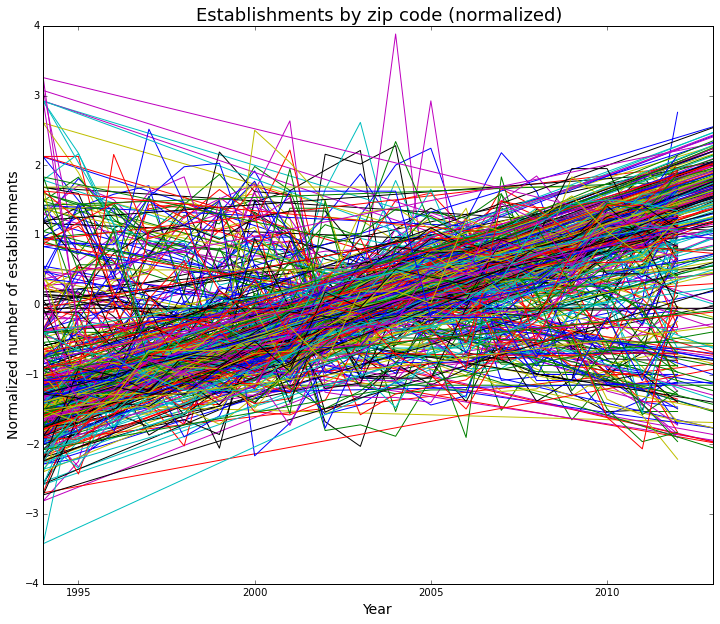

In [34]:
# initial plotting
plt.figure(figsize=(12,10))
for zipcode in mydata.index:
    plt.plot(mydata.columns, mydata.ix[zipcode])
plt.xlim(1994, 2013)
plt.xlabel('Year', size=14)
plt.ylabel('Normalized number of establishments', size=14)
plt.title('Establishments by zip code (normalized)', size=18)

plt.show()

# Clustering

In [47]:
# did not complete homework, will work through rest later this week. 